##### Script to calculate Condidence interval of RMSE using Bootstraping method
###### Abhishek Savita- GEOAMR-2022/11/04:

In [1]:
#Importing  important libraries those need for arthmatic calculations and  for regiona maps
import glob
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.ticker as tck
import cmocean
import matplotlib.colors as colors
from scipy import stats
import xskillscore as xs

In [2]:
# read multiple files (wildcard)
files001 = glob.glob('/data/user/asavita/foci/openifs-43r3/OIFS-BAS001/outdata/oifs/*1m*sfc*.nc') #100km and 30m time step
data001  = xr.open_mfdataset(files001)#100km and 30m time step
data0era = xr.open_dataset('/data/user/asavita/data_observations/ERA5/Monthly/1deg/ERA5_u10_v10_1979-2021_mon.nc')   # data from era intrim
# Time extracting 
data001     = data001.sel(time_counter=slice('1979-01-01','2019-12-31'))#.mean('time_counter',keep_attrs=True)
data0era     =data0era.rename({'time': 'time_counter'})
data0era    = data0era.sel(time_counter=slice('1979-01-01','2019-12-31'))#.mean('time_counter',keep_attrs=True)
data0era    =data0era.rename({'latitude': 'lat'})
data0era    =data0era.rename({'longitude': 'lon'})

##### Surface zonal wind i.e. u10

In [3]:
## Root mean square calculation fr gobal average values
#### Annual RMSE Error at land and Ocean
u10_var_anual_001 =data001['10u'].mean('time_counter') #.values.flatten()
u10_var_anual_era5 =data0era['u10'].isel(expver=0).mean('time_counter') #.values.flatten()

#Weight
weights_lat = np.cos(np.deg2rad(u10_var_anual_001.lat))
weights_lat /= weights_lat.mean()
#
u10_var_anual_00_int =u10_var_anual_001.interp_like(u10_var_anual_era5)#*weights_lat
u10_var_anual_era5=u10_var_anual_era5#*weights_lat

#Converting in to a single array
u10_var_anual_001_flat =(u10_var_anual_00_int).fillna(0).values.flatten()#.dropna()
u10_var_anual_era5_flat =(u10_var_anual_era5).fillna(0).values.flatten()#.dropna()


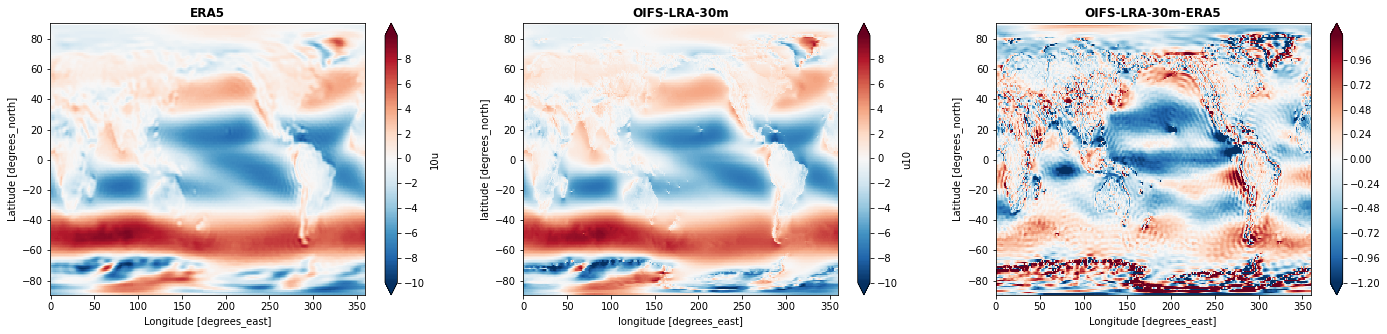

In [4]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=[24,5])
u10_var_anual_00_int.plot(ax=ax1, levels=np.arange(-10,10,0.1),robust=True,extend='both')
ax1.set_title('ERA5',fontsize=12, fontweight='bold')
u10_var_anual_era5.plot(ax=ax2,levels=np.arange(-10,10,0.1),robust=True,extend='both')
ax2.set_title('OIFS-LRA-30m',fontsize=12, fontweight='bold')
(u10_var_anual_00_int-u10_var_anual_era5).plot(ax=ax3,levels=np.arange(-1.2,1.2,0.001),robust=True,extend='both')
ax3.set_title('OIFS-LRA-30m-ERA5',fontsize=12, fontweight='bold')
plt.show()

In [5]:
def corr_r(x, y):
    """
    Compute plug-in estimate for the pearson or bivariate correlation coefficient.
    """
    cor=np.corrcoef(x, y)
    corr1=cor[0,1]
    return corr1

def rmse_fun(x, y):
    """
    Estimate for root mean square errro.
    """
    error = x - y
    rmse=np.sqrt(((error)**2).mean())
    return rmse

#http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/lessons/lesson_07/pairs_bootstrap_correlation.html
### Bootstraping function
def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def draw_bs_pairs(x, y):
    """Draw a pairs bootstrap sample."""
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)

    return x[bs_inds], y[bs_inds]

def draw_bs_pairs_reps_bivariate_corr(x, y, iteration=1):
    # x array data #y=arra data #iteration=number of iteration
    #fun = funtion that compite stastics such as corre, remse etc which is defined by user seperately
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(iteration)

    for i in range(iteration):
        out[i] = corr_r(*draw_bs_pairs(x, y))
    #print(out)
    return out

def draw_bs_pairs_reps_bivariate_rmse(x, y, iteration=1):
    # x array data #y=arra data #iteration=number of iteration
    #fun = funtion that compite stastics such as corre, remse etc which is defined by user seperately
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(iteration)

    for i in range(iteration):
        out[i] = rmse_fun(*draw_bs_pairs(x, y))
    #print(out)
    return out


In [6]:
# Get reps
corre_001 = draw_bs_pairs_reps_bivariate_corr(u10_var_anual_era5_flat, u10_var_anual_001_flat, iteration=2000)

rmse_001 = draw_bs_pairs_reps_bivariate_rmse(u10_var_anual_era5_flat, u10_var_anual_001_flat, iteration=2000)


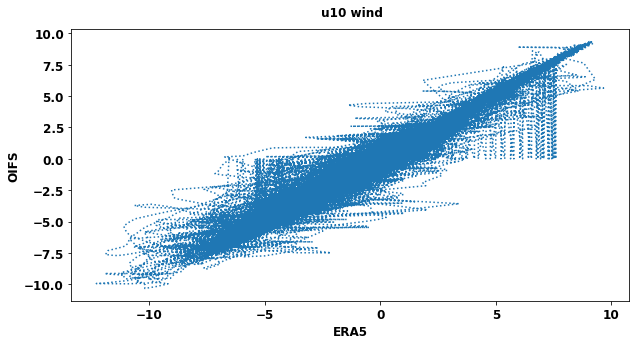

In [19]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax1 = plt.subplots(figsize=[10,5])
#fig = plt.figure(figsize=[20,10])
ax1.plot(u10_var_anual_era5_flat,u10_var_anual_001_flat, linestyle = 'dotted')
ax1.set_xlabel('ERA5')
ax1.set_ylabel('OIFS')
ax1.set_title(' u10 wind', y=1.12,pad=-20,fontsize=12,fontweight='bold')
plt.show()

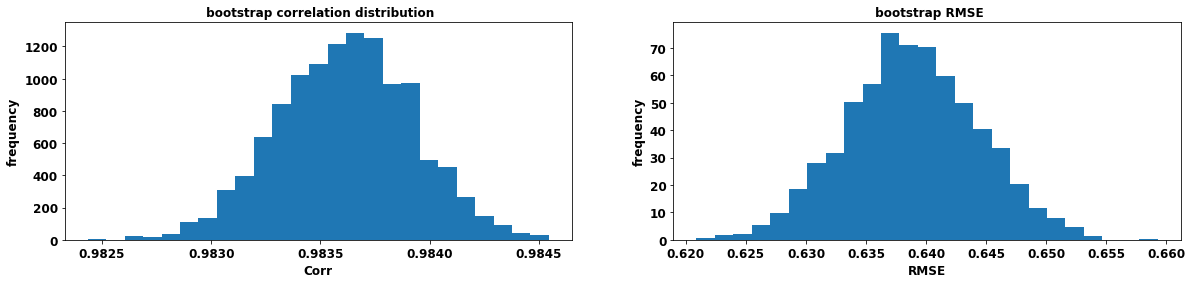

In [20]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2)= plt.subplots(1,2,figsize=[20,4])
#fig = plt.figure(figsize=[20,10])
ax1.hist(corre_001,bins=25,density=True)
ax1.set_xlabel('Corr')
ax1.set_ylabel('frequency')
ax1.set_title(' bootstrap correlation distribution', y=1.12,pad=-20,fontsize=12,fontweight='bold')

ax2.hist(rmse_001,bins=25,density=True)
ax2.set_xlabel('RMSE')
ax2.set_ylabel('frequency')
ax2.set_title(' bootstrap RMSE', y=1.12,pad=-20,fontsize=12,fontweight='bold')
plt.show()

In [21]:
def Prob_dist_plot(var1,nrows,ncol,nsub,vartitle,xlabel_text,ylabel_text):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ax=fig.add_subplot(nrows,ncol,nsub)
    sns.histplot(var1, color='gray', stat='density', edgecolor="gray")
    sns.kdeplot(var1, color='blue')
    #plt.axvline(var2, 0, 0.95, color='black')
    #plt.ayhline(x=0.0, color='gray', linestyle='--')
    plt.axvline(var1.mean(axis=0), 0, 0.95, color='darkorange')
    plt.axvline(var1.mean(axis=0)+2*var1.std(axis=0), 0, 0.95, color='darkorange', linestyle='--')
    plt.axvline(var1.mean(axis=0)-2*var1.std(axis=0), 0, 0.95, color='darkorange', linestyle='--')
    ax.set_ylabel(ylabel_text,position=(0.1,0.5),fontsize=16,fontweight='bold')
    ax.set_xlabel(xlabel_text,position=(0.5,0.5),fontsize=16,fontweight='bold')
    ax.set_title(vartitle, y=1.12,pad=-20,fontsize=12,fontweight='bold')
    ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True,size=5,width=4)
    plt.rcParams['font.size']='12'
    plt.rcParams['font.weight']='bold'
    plt.rcParams['axes.labelweight']='bold'
    #ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.legend(['Distribution','Mean', 'mean+2*std', 'mean+2*std'],loc='upper right', bbox_to_anchor=(0.0005, 0.95),mode = "expand", ncol = 1,shadow=False, framealpha=None, frameon=False)
    plt.tight_layout; plt.draw()

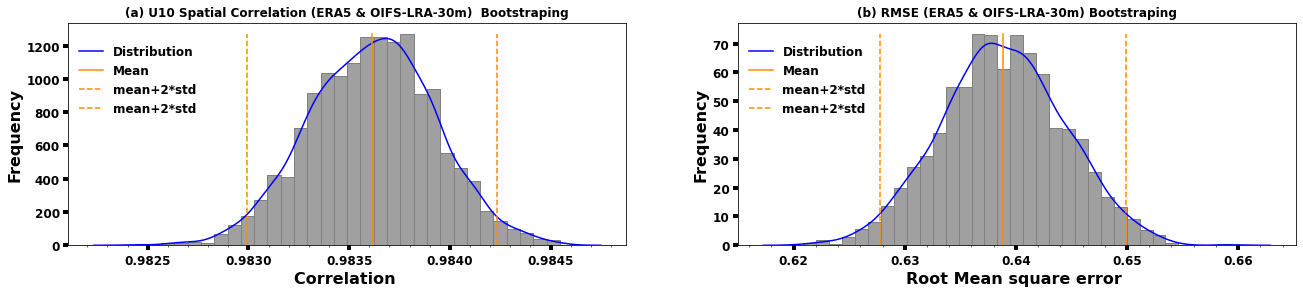

In [22]:
fig = plt.figure(figsize=[22,9])
Prob_dist_plot(corre_001,2,2,1,
               '(a) U10 Spatial Correlation (ERA5 & OIFS-LRA-30m)  Bootstraping','Correlation ', 'Frequency')
Prob_dist_plot(rmse_001,2,2,2,
               '(b) RMSE (ERA5 & OIFS-LRA-30m) Bootstraping','Root Mean square error ', 'Frequency')


In [23]:
# Computing confidence interval using 25 and 95 percentile function
## Note; The difference between above method and percentile method is very small, i.e. 10^-5, which is negligble

In [24]:
# Get the confidence intervals
conf_corre_001 = np.percentile(corre_001, [2.5, 97.5])
conf_rmse_001 = np.percentile(rmse_001, [2.5, 97.5])


In [25]:
def Prob_dist_plot_perceintile(var1,var_25,var97,nrows,ncol,nsub,vartitle,xlabel_text,ylabel_text):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ax=fig.add_subplot(nrows,ncol,nsub)
    sns.histplot(var1, color='gray', stat='density', edgecolor="gray")
    sns.kdeplot(var1, color='blue')
    plt.axvline(var1.mean(axis=0), 0, 0.95, color='darkorange')
    plt.axvline(var_25, 0, 0.95, color='darkorange', linestyle='--')
    plt.axvline(var97, 0, 0.95, color='darkorange', linestyle='--')
    ax.set_ylabel(ylabel_text,position=(0.1,0.5),fontsize=16,fontweight='bold')
    ax.set_xlabel(xlabel_text,position=(0.5,0.5),fontsize=16,fontweight='bold')
    ax.set_title(vartitle, y=1.12,pad=-20,fontsize=12,fontweight='bold')
    ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True,size=5,width=4)
    plt.rcParams['font.size']='12'
    plt.rcParams['font.weight']='bold'
    plt.rcParams['axes.labelweight']='bold'
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.legend(['Distribution','Mean', '2.5 percentile', '97.5th percentile'],loc='upper right', bbox_to_anchor=(0.0005, 0.95),mode = "expand", ncol = 1,shadow=False, framealpha=None, frameon=False)
    plt.tight_layout; plt.draw()

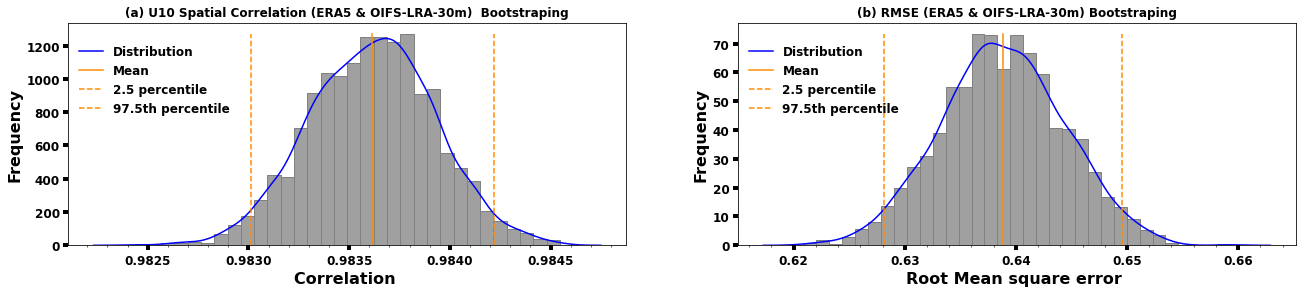

In [26]:
fig = plt.figure(figsize=[22,9])
Prob_dist_plot_perceintile(corre_001,conf_corre_001[0],conf_corre_001[1],2,2,1,
               '(a) U10 Spatial Correlation (ERA5 & OIFS-LRA-30m)  Bootstraping','Correlation ', 'Frequency')
Prob_dist_plot_perceintile(rmse_001,conf_rmse_001[0],conf_rmse_001[1],2,2,2,
               '(b) RMSE (ERA5 & OIFS-LRA-30m) Bootstraping','Root Mean square error ', 'Frequency')


In [27]:
# Comparing confidence interval (lower limit ) between two methods

In [28]:
conf_corre_001[0]

0.9830111354663278

In [29]:
corre_001.mean(axis=0)+2*corre_001.std(axis=0)

0.9842346823256071

In [30]:
conf_corre_001[0]-corre_001.mean(axis=0)+2*corre_001.std(axis=0)

1.602548554731592e-05